<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />

# From Centralised to Decentralised Training: An Intro to Federated Learning

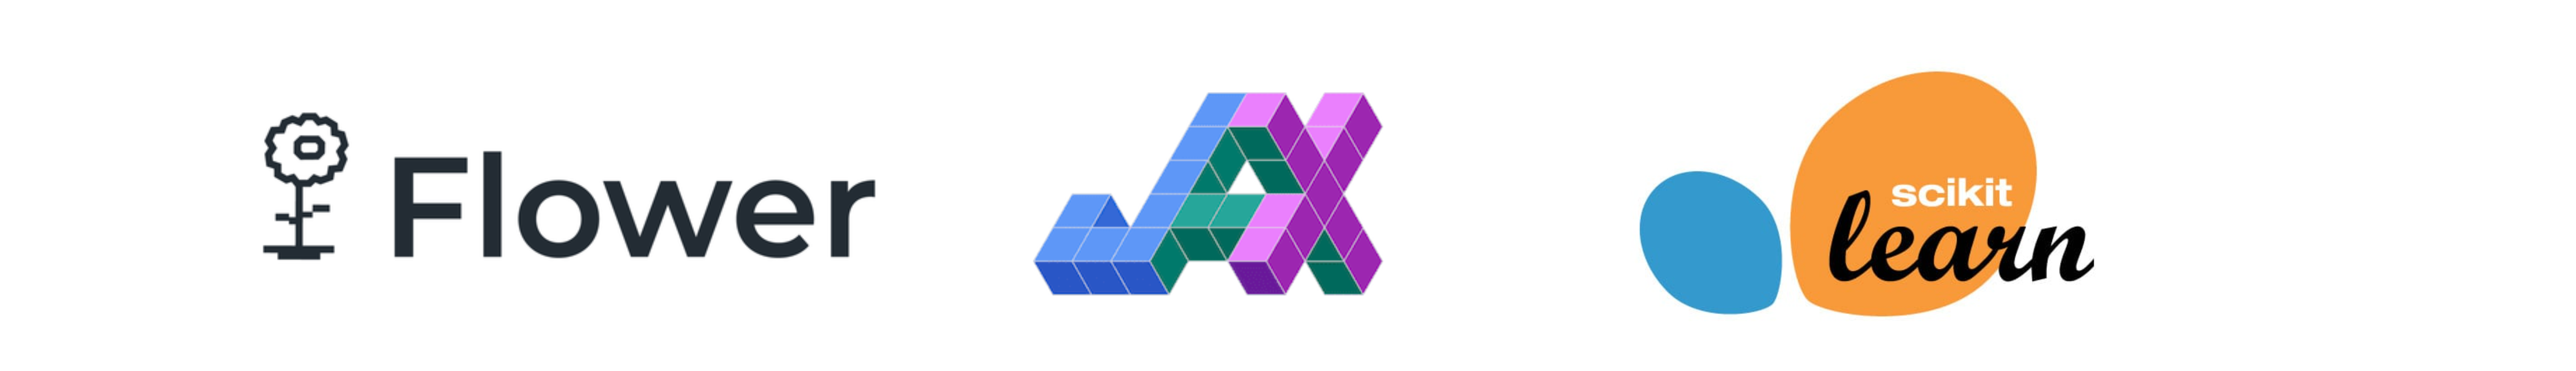


<!-- <div style="display: inline-block">
<br>
<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Indaba_Prac_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div> -->

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** *Andrej Jovanović*, *Sree Harsha Nelaturu* and *Luca Powell*

**Reviewers:** *TBD*

### **Topics:**
<font color='grey'>`Federated Learning`</font>  <font color='grey'>`Neural Networks`</font> <font color='grey'>`Machine Learning`</font>

### **Aims/Learning Objectives:**

Federated Learning (FL) is a growing research area with a number of existing applications and numerous reseach papers presented at conferences, journals and workshops each year. While this is great for research and industry experts who have a thriving FL community, the rapid innovations in FL implicitly create a barrier of entry for those wanting to enter the space and understand FL from a first principles perspective. Despite FL being a relatively simple concept at its core, it can be implemented in numerous ways and includes a great deal of domain-specific jargon that can leave newcomers feeling overwhelmed or alientated initially. Our practical is aimed at bridging this gap. We want to provide a beginner-focused introduction to FL, stripping away any fancy bells and whistles such that focus is placed on the foundational concepts. We want you to leave the practical with a good enough understanding such that you can explain Federated Learning to someone else, and such that you can intuit when Federated Learning could be useful in future scenarios you might encounter.

Formally, we aim to achive the following:
1. Provide a first principles intuitive understanding of Federated Learning.
2. Clarify common FL terminology in the literature with examples.
3. Highlight the differences between centralised and decrentalised training.
4. Provide an introduction to Flower, a powerful open-source Federated Learning framework.

### **Prerequisites:**

We have tried to make this practical as introductory as possible. We introduce the basics of Federated Learning and assume that you have a basic understanding of the following machine learning principles and toolkits:

* Python
* NumPy
* Basic probability theory
* Knowledge of classical machine learning, for example regression and classification problems
* Neural Networks

Suggested experience level in this topic: <font color='grey'>`Beginner`</font>

<div style="display: inline-block">
    
| Level         | Experience                            |
| :-- | :-- |
| `Beginner`      | It is my first time being introduced to this work. |
| `Intermediate`  | I have done some basic courses/intros on this topic. |
| `Advanced`      | I work in this area/topic daily. |

</div>

### **Outline:**
The practical will be structured as follows:

**Section 1:** An introduction into Federated Learning, viewed from the lens of a distributed optimisation problem.

**Section 2:** Explanation of the various terms and jargon used in Federated Learning.

**Section 3:** Your First FL Example -- Non-Linear Regression.

**Section 4:** Direct comparison between centralised and decentralised training using Federated Learning.

## TODO BEFORE PRAC: Installation and Imports (Run Cell)

We are going to be installing some relevant packages that we need to do this practical. Do not worry - this is not important for your understanding. We just need to make sure that you have everything setup so that you are ready to rock and roll on the day!

In [ ]:
%%capture
# Download the necessary packages - jax, sklearn, flower
!pip install jax jaxlib scikit-learn flwr_datasets optax flax ipywidgets torch torchvision "flwr[simulation]"

# Download data locally
from datasets import load_dataset
load_dataset("zalando-datasets/fashion_mnist", cache_dir="./data")

## TODO AT PRAC: Import required packages. (Run Cell)


In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import tqdm

import jax.random as random
import optax
import flax
from flax import linen as nn
from flax.training import train_state
import functools

from typing import Dict, List, Tuple, Callable, NamedTuple, Any
from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from datasets import load_dataset
from ipywidgets import interact

key = random.PRNGKey(42)

---
## Section 1: Introduction <a class="anchor" id="section-1"></a>
---

### 1.1 What is Federated Learning? 

Let's suppose we want to train a next-word suggestion model to suggest useful next-words based on what a user is typing on their smartphone keyboard. How can we make this model learn from entire populations of smartphone users without exposing any specific user's typing activity or habits (highly sensitive data)? This is exactly the kind of problem that informed the emergence of **Federated Learning (FL)**. Federated Learning is a strategy for training statistical models on a number of remote devices, called ***clients***, without directly accessing client data and thus maintaining user privacy.

### 1.2 So How Does FL Work?

In contrast to conventional ML that employs ***centralised*** training (i.e., training on data that was pre-collected and stored on a central device or server), FL instead leverages ***decentralised*** training: training on data that is distrubutedly stored among clients. In effect, we push the computation to the edge with FL. Another way of saying this is the client devices are the ones doing the training. This allows us to train ML models while inherently promoting privacy as the training data never has to leave these clients. The central problem of FL is to learn a single "global" model from the decentralised client data by communicating the client model updates to a ***parameter server***. A typical server-client FL system maintains a centralised server that synchronises training across iterations of so-called federated training ***rounds***.

A single FL round generally proceeds as follows:

1. At the beginning of a round, the parameter server sends a copy of the global model to each client.
2. The clients each train their copy of the model for a number of local epochs on their local dataset (client datasets are called ***partitions***), and send the post-training model updates to the server.
3. The server then aggregates all the updated client models to form a single federated or _global_ model update which forms the global model for the next round.

This procedure is shown below.

<!-- Conventional machine learning approaches predominantly employ **centralised** training, where all the training data is pre-collected and stored on a single (central) device or server. However, this centralised setup is not always viable. In many cases, data cannot be transferred freely from the data-generating locations (edge devices) to a central server. For example, the sharing of sensitive data is restricted due to privacy concerns in the medical domain. This renders traditional centralised training ineffective. To solve this problem, federated learning, a training framework that is the reverse of centralised training, has been proposed. In effect, we push the computation to the edge with federated learning, allowing us to train machine learning models that inherently promote privacy as the training data never leaves the edge device.


The central problem of FL is to learn a single global model from the decentralised client data by processing this data on-device and communicating the corresponding model updates to a parameter server.

The most common form of FL is called _**cross-device FL**_. This is concerned with collaboratively training models on edge devices or “clients'' encapsulating their private data. As such, FL may:
- Reduce communication costs by only sharing model parameters.
- Distribute computation across a pool of previously unused devices.
- Partially preserve privacy by default.


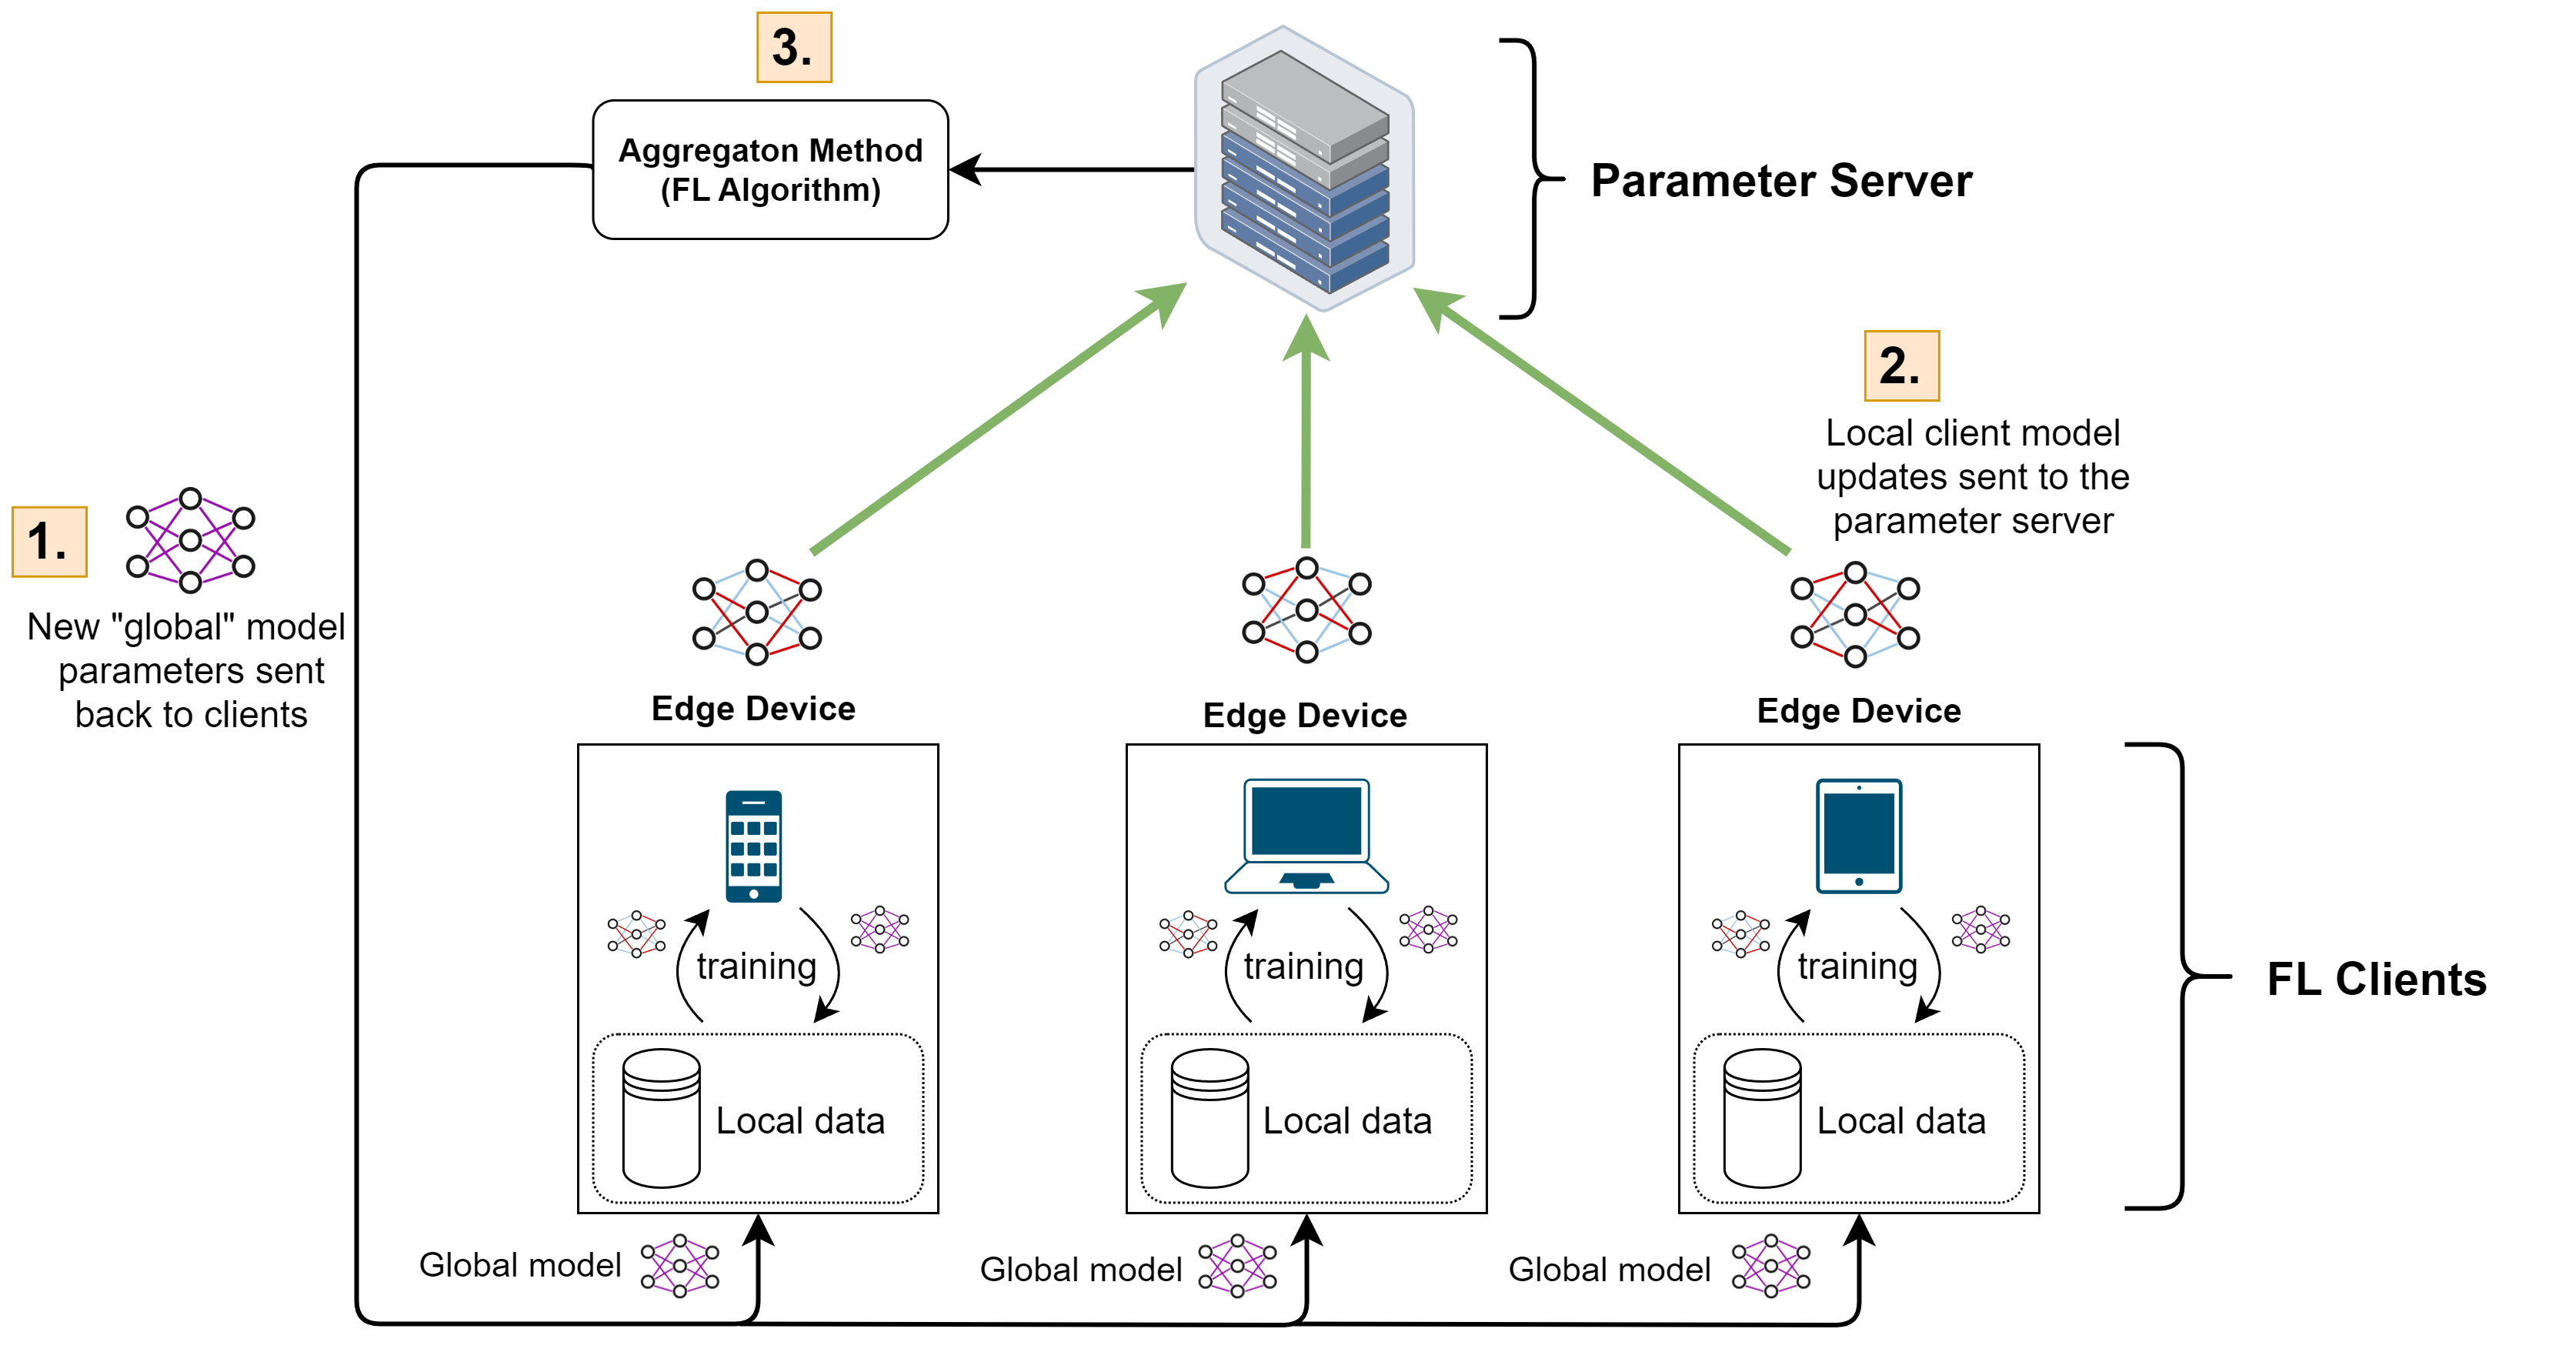

---
## Section 2: Federated Learning Concepts <a class="anchor" id="section-2"></a>
---

### 2.1 Model Aggregation Strategies

We can think of Federated Learning as trying to solve a global optimisation problem (achieving an overall well-performing model) by solving a number of smaller optimisation objectives (i.e., minimising each client's loss functions) at the same time. This is where the notion of model aggregation comes in. The core idea is that an aggregate of all of the small optimisation steps should result in an overall step towards the global optimisation objective.

#### Federated Averaging - The Finite Sum Formulation

The first-proposed form of model aggregation is **Federated Averaging (FedAvg)**. FedAvg can be expressed using the finite sum formulation, where instead of solving multiple different objectives we solve a global optimisation problem which is the weighted average of the individual objective functions:

$\min_{x} f(x) = \frac{1}{N}\sum_{i=1}^k n_i\cdot f_i(x) = \frac{\sum_{i=1}^k n_i\cdot f_i(x)}{\sum_{i=1}^k n_i}$

Making a comparison with the federated learning setup: 

**$f(x)$**: The global model we are training through aggregation at the parameter server.

**$f_i(x)$**: The individual models we are training on the clients (client objectives).

**$k$**: The number of clients.

**$n_i$**: The number of training examples belonging to each client respectively.

**$N$**: The total number of training examples across all clients.

Note the FedAvg includes the following restrictions for improved stability of the global model:

* A consistent number of local epochs across clients; each client iterates over their entire dataset for the provided number of epochs.
* The weighting assigned to any client's objective (i.e. model update) is proportional to its relative local dataset size. We  wouldn't want a client with only 5 training examples to make the same contribution as a client with 5000 training examples - can you think of the reason why?

### 2.2 Data Heterogeneity

Perhaps the greatest limitation of the FedAvg algorithm is its assumption that client partitions are ***independent and identically distributed*** **(IID)**. This means we assume the data at every client was been generated from the same underlying process, meaning that if we train and the model does well on one client's data, this performance will translate well to other unseen clients. Do you see how this is a very optimistic assumption? Data from various sources (clients) is naturally different or *heterogeneous* in properties, client partitions are therefore likely to be non-IID with each other. In summary:

**IID Data:** Data is IID if the underlying probability distribution of the data-points is the same, and each point is generated independent of each other.

**Non-IID Data:** Data is non-IID if the underlying probability distribution of the data-points is different for each client.

The case where client partitions differ in distribution and other properties is referred to as ***Data Heterogeneity***.

#### 2.2.1 Non-IID Example - Apples and Oranges

To illustrate non-IID data, let's consider a scenario where we want to train a neural network to distinguish between apples and oranges for an automatic assembly line at a fruit packaging facility. If the training set contains images of exclusively <span style="color:green">**green**</span> apples, what would happen if the test set then only contains images of <span style="color:#C00000">**red**</span> apples? In this case, the training and test sets are non-IID. 

We can think of the training and test sets as having been generated from two different probability distributions - one with higher likelihood for generating green pixels and one with higher likelihood for red pixels. It is difficult to know exactly how the model would react to this, but it is likely it would perform worse than expected on the test set since the it might have learned to associate green colours with apples and orange colours with oranges. 

If we want to more closely match the IID assumption, we would need to aim for equal representation of red and green apples in both the training and test sets such that they both resemble samples from roughly the same underlying distribution.

![iid-visualisation-1.png](etc/iid-visualisation-1.png)

#### 2.2.2 Non-IID Label Skew

In supervised learning problems, *label skew* is a common condition making client partitions non-IID. This means the representation of specific classes (i.e. proportions of class labels) varies from client to client. Let's first illustrate this by creating a synthetic dataset with 1,000 training examples each belonging to 1 of 10 classes.

In [ ]:
from sklearn.datasets import make_blobs

N = 1000 # Training examples
d = 2 # Dimension of each data point (i.e., number of features)
num_classes = 10

# Create a synthetic dataset with `num_classes` well-separated classes
x, y = make_blobs(n_samples=N, n_features=d, centers=num_classes, random_state=42)

plt.figure(figsize=(5, 3))
for label in range(num_classes):
    plt.scatter(x[(y==label), 0], x[(y==label), 1])
plt.title(f'Synthetic 10-class Dataset (N={N})')
plt.xlabel('Feature $x_0$'), plt.ylabel('Feature $x_1$');


Note this dataset is balanced, meaning the number of datapoints belonging to each class is constant, given by

$N_j = \frac{N}{C} \,\,\,,\,\,\, j = \{0, 1, 2, ..., C-1\}$

where $N$ is the total number of training examples, $N_j$ is the number of training examples belonging to class $j$, and $C$ is the total number of classes.

Now, let's partition (i.e. split) this dataset among 5 clients. Note this is a common practice in FL research, since benchmark classification problems such as MNIST or CIFAR10 are centralised datasets and must be artificially partitioned in order do FL experiments.

For those interested, our partitioning scheme uses an algorithm called Latent Dirichlet Allocation (LDA) to control the degree of label skew depending on a parameter called `iid-alpha`. However, you do not need to understand how this code works in detail. Please run the cell and proceed.

In [ ]:
# TODO: Hide this cell?

XY = tuple[np.ndarray, np.ndarray] # (X, Y)
XYList = list[XY]
PartitionedDataset = tuple[XYList, XYList]

np.random.seed(1337)

def sort_by_label(x: np.ndarray, y: np.ndarray) -> XY:
    """Sort training examples x by their class labels y."""
    idx = np.argsort(y, axis=0).reshape(y.shape[0])
    return (x[idx], y[idx])

def shuffle(x: np.ndarray, y: np.ndarray) -> XY:
    """Shuffle x and y."""
    idx = np.random.permutation(len(x))
    return x[idx], y[idx]

def split_array_at_indices(
    x: np.ndarray, split_idx: np.ndarray
) -> list[list[np.ndarray]]:
    """Splits an array `x` into list of elements using starting indices from
    `split_idx`.

    """

    num_splits: int = len(split_idx)
    split_idx = np.append(split_idx, x.shape[0])

    list_samples_split: list[list[np.ndarray]] = [[] for _ in range(num_splits)]
    for j in range(num_splits):
        tmp_x = x[split_idx[j] : split_idx[j + 1]]
        for sample in tmp_x:
            list_samples_split[j].append(sample)

    return list_samples_split

def exclude_classes_and_normalize(
    distribution: np.ndarray, exclude_dims: list[bool], eps: float = 1e-5
) -> np.ndarray:
    """Excludes classes from a distribution.

    This function is useful when sampling without replacement.
    Classes for which no sample is available have their probabilities set to 0.
    Classes that had probabilities originally set to 0 are incremented with
     `eps` to allow sampling from remaining items.

    """
    if np.any(distribution < 0) or (not np.isclose(np.sum(distribution), 1.0)):
        raise ValueError("distribution must sum to 1 and have only positive values.")

    if distribution.size != len(exclude_dims):
        raise ValueError(
            """Length of distribution must be equal
            to the length `exclude_dims`."""
        )
    if eps < 0:
        raise ValueError("""The value of `eps` must be positive and small.""")

    distribution[[not x for x in exclude_dims]] += eps
    distribution[exclude_dims] = 0.0
    sum_rows = np.sum(distribution) + np.finfo(float).eps
    distribution = distribution / sum_rows

    return distribution

def sample_without_replacement(
    distribution: np.ndarray,
    list_samples: list[list[np.ndarray]],
    num_samples: int,
    empty_classes: list[bool],
) -> tuple[XY, list[bool]]:
    """Samples from a list without replacement using a given distribution.
    
    """
    
    if np.sum([len(x) for x in list_samples]) < num_samples:
        raise ValueError(
            """Number of samples in `list_samples` is less than `num_samples`"""
        )

    # Make sure empty classes are not sampled
    # and solves for rare cases where
    if not empty_classes:
        empty_classes = len(distribution) * [False]

    distribution = exclude_classes_and_normalize(
        distribution=distribution, exclude_dims=empty_classes
    )

    data: list[np.ndarray] = []
    target: list[np.ndarray] = []
    
    for _ in range(num_samples):
        sample_class = np.where(np.random.multinomial(1, distribution) == 1)[0][0]
        sample: np.ndarray = list_samples[sample_class].pop()
        
        data.append(sample)
        target.append(sample_class)

        # If last sample of the class was drawn, then set the
        #  probability density function (PDF) to zero for that class.
        if len(list_samples[sample_class]) == 0:
            empty_classes[sample_class] = True
            # Be careful to distinguish between classes that had zero probability
            # and classes that are now empty
            distribution = exclude_classes_and_normalize(
                distribution=distribution, exclude_dims=empty_classes
            )
    data_array: np.ndarray = np.concatenate([data], axis=0)
    target_array: np.ndarray = np.array(target, dtype=np.int64)

    return (data_array, target_array), empty_classes

def create_lda_partitions(
    dataset: XY,
    num_partitions: int = 10,
    concentration: float | np.ndarray | list[float] = 0.5,
    seed: int | None = None,
) -> tuple[XYList, np.ndarray]:
    """Create imbalanced non-iid partitions using Latent Dirichlet Allocation
    (LDA) without resampling.
    
    """
    
    x, y = dataset
    x, y = shuffle(x, y)
    x, y = sort_by_label(x, y)
    
    # get the number of samples for each class
    num_samples = num_partitions * [0]
    for j in range(x.shape[0]):
        num_samples[j % num_partitions] += 1 # count samples belonging to class j
    
    # Get number of classes and start indices (y was already sorted)
    classes, start_indices = np.unique(y, return_index=True)
    
    # Make sure that concentration is np.array and
    # check if concentration is appropriate
    concentration = np.asarray(concentration)

    # initialise partitions object to be returned
    partitions: list[XY] = [(_, _) for _ in range(num_partitions)]

    concentration = np.repeat(concentration, classes.size)
    
    # Split into list of list of samples per class
    list_samples_per_class: list[list[np.ndarray]] = split_array_at_indices(
        x, start_indices
    )

    dirichlet_dist = np.random.default_rng(seed).dirichlet(
        alpha=concentration, size=num_partitions
    )

    # Assuming balanced distribution
    empty_classes = classes.size * [False]
    for partition_id in range(num_partitions):
        partitions[partition_id], empty_classes = sample_without_replacement(
            distribution=dirichlet_dist[partition_id].copy(),
            list_samples=list_samples_per_class,
            num_samples=num_samples[partition_id],
            empty_classes=empty_classes,
        )

    return partitions, dirichlet_dist

Finally, we are ready to see how the magic happens! Run the cell below, and play around with the IID Alpha parameter to see how this effects each of the local client distributions.

In [ ]:
num_clients = 3
iid_alphas = [0.1, 0.2, 0.5, 1.0, 10, 1000, 100000]

def plot_partitions(iid_factor=3):
    
    # partition the centralised dataset based on num_clients and iid_factor
    client_partitions, _ = create_lda_partitions(
        dataset=(x, y), num_partitions=num_clients, 
        concentration=iid_alphas[iid_factor], seed=13
    )
 
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle(f"Client Partitions (iid-alpha={iid_alphas[iid_factor]})", 
                 fontsize=17)

    gs = fig.add_gridspec(2, num_clients)
    axarr = [None]*num_clients # store each client's plot axes in a list
    
    # class representation plot
    ax_bottom = fig.add_subplot(gs[1, :]) # axes
    xticks = np.arange(num_classes)  # label locations for bottom plot
    xlabels = [f"Class {i}" for i in xticks] # xtick labels for bottom plot
    width = 0.12  # the width of the bars
    multiplier = 0 
    
    # create subplots "Client 1" to "Client `num_clients`"
    for c in range(num_clients):
        partition_x, partition_y = client_partitions[c]
        axarr[c]= fig.add_subplot(gs[0, c]) 
        
        # scale x and y limits for consistent class cluster locations
        axarr[c].set(title=f"Client {c+1}", 
                     xlim=[min(x[:, 0])-0.5, max(x[:, 0])+0.5],
                     ylim=[min(x[:, 1])-0.5, max(x[:, 1])+0.5])
        
        # scatter plot all class clusters for current client
        for label in range(num_classes):
            axarr[c].scatter(partition_x[(partition_y==label), 0], 
                             partition_x[(partition_y==label), 1]) 

        # add current client's class distribution to bottom plot
        hist_c, _ = np.histogram(client_partitions[c][1], 
                                 bins=list(range(num_classes + 1)))
        offset = width * multiplier
        rects = ax_bottom.bar(xticks + offset, hist_c, width, 
                              label=f"Client {c+1}")
        multiplier += 1
    
    ax_bottom.set_title('Class Representation')
    ax_bottom.set_ylabel('Number of samples')
    ax_bottom.set_xticks(xticks + width, xlabels)
    ax_bottom.legend(loc='upper left');

slider = interact(plot_partitions, iid_factor=(0, len(iid_alphas)-1))

**Questions:**

* What happens to the class balance among clients when the partitions are more non-IID (i.e. when the `iid-alpha` parameter is smaller)?
<details>
<summary><font color='black'><b> Click for answer </b> </font> </summary>
    The class representations become increasingly imbalanced, and possibly containing no samples from certain classes.
</details>

* In the worst case scenario, some client partitions contain **zero** examples from certain classes. If we trained a copy of the global model on such a partition, how would the updated model perform on a reserved test set which does in fact contain these classes?
<details>
<summary><font color='black'><b> Click for answer </b> </font> </summary>
    We do not know exactly what would happen. There could be some knowledge transferred from some of the classes that were included in the training set. However, this is not guaranteed. In the worst case, if the unseen samples are completely distinct from the training samples, the model would perform similarly to a randomly initialised model.
</details>

* (Advanced/Optional) With non-IID partitions, wouldn't all of the class imbalance be accounted for when we aggregate the client model updates?
<details>
<summary><font color='black'><b> Click for answer </b> </font> </summary>
    Not necesarily. Let's think of it in this way: considering the entire dataset as one whole, the update that the model will take will be in, some sense, a direction that is optimal for all the classes. However, highly heterogenous client partitions may result in model updates that are specifc for that local dataset. Not only that, each client's model updates can be in a completely opoosite direction relative to another client when considering the global update. As such, when you average two vectors in oposing directions, you will get a smaller vector that may not be aligned with the global optimisation direction. As such, the global model can become very unstable in cases of very high client heterogeneity. If you are struggling to wrap your head around this (as we initial did), please ask a tutor for a further explanation.
</details>


### 2.3 Device Heterogeneity

Client devices vary significantly in terms of speed and connectivity, posing another challenge for FL algorithms like FedAvg. In particular, synchronous FL algorithms wait for all clients to finish their local epochs before aggregating and starting a new round. The problem here, as you can imagine, is that slower clients (referred to as *stragglers*) can be a bottleneck slowing the overall FL training. 


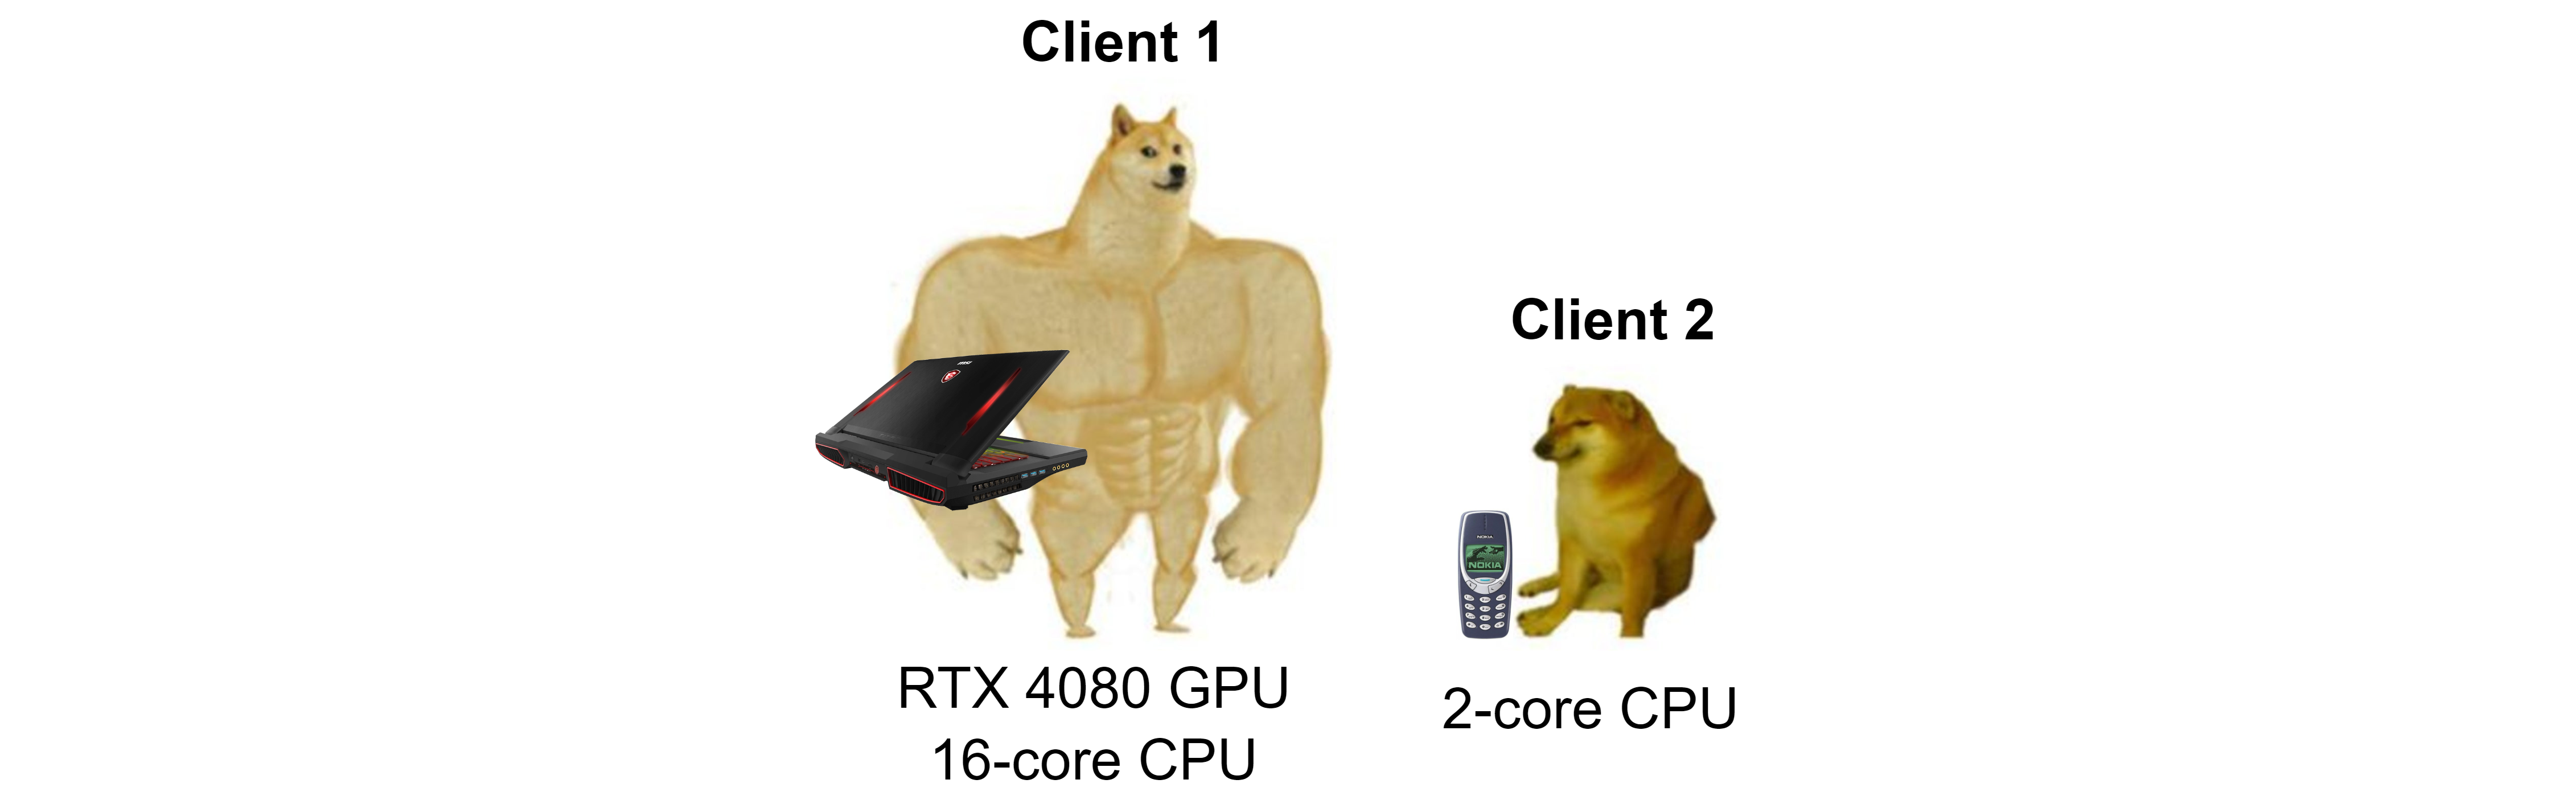

### 2.4 Summary of FL Concepts

Well done! By this point, you have been exposed to some of the foundational concepts for FL, and should understand the general setup and some of the challenges associated with it. 

Now it's time to start implementing FL yourself! Here is a summary of the key concepts we covered. Be sure to scroll back to this if you get stuck later on!

* Aggregation Strategy
* Clients: 
* Paramter Server:
* Data Heterogeneity
* IID vs Non-IID
* Device Heterogeneity

---
## Section 3: Your First FL Example -- Non-Linear Regression <a class="anchor" id="section-3"></a>
---

### 3.1 Today's example -- Non-Linear Regression 

In a standard regression task, we attempt to fit a model to the data as a non-linear combination of the model's features present. We assume we have some function $f(x)$ which will produce a non-linear mapping from input space $x$ to the output space $\hat{y}$.

In a standard setup (continuing the use of linear regression), you would create a non-linear decision boundary through the use of basis functions (see Section 3.1 in Pattern Recognition and Machine Learning by Chris Bishop for a rigourous treatment of this). However, in our case, we will use a neural network with non-linear activation functions to learn the mapping instead. Much simpler and less maths :D!

We will be using JAX today to do multiple things:
(1) Generate our example datasets, very cool: this takes advantage of how JAX deals with random numbers (add reference).
(2) The dataset have two variants: iid and non-iid. Will elaborate more on this in the next section!
(2) We will define our simple neural network using flax (https://flax.readthedocs.io/en/latest/) using the linen API -- a very common and powerful abstraction to define and work with deep learning in JAX. The optimizers however comes from Optax, because it do be like that sometimes.
(3) We will then use the Federated Averaging (FedAvg) algorithm to fit our model to the data, this will involve a few extensions to our earlier definition, which will be described in more detail as we go along.

In today's regression example, we will be generating regression data. A typical regression can consist of a single, or multiple features (which might dependent or independent of each other -- we often find out these things the hard way -- through experiencing disdain after a model does not perform well).

The total "number" of data-points remains the same across all clients, as we don't want our example to be more complicated than it needs to be. But it is good to note that in realistic settings, in addition to "label skew" (some classes have more data than other classes) there can also be "quantity skew" which implies that some clients just have very small datasets compared to others.

### 3.2 Generating An Example Dataset

For the first task, you will generate the data and also set the experiment parameters. Please first read through a quick recap of what each variable represents and set them according to your choice.

- **n_features** - number of features present in our function, in order to easily visualize our data -- this will remain **fixed** at 2.
- **n_samples** - given a function, how many samples do you want present in your dataset (lower the number of samples, faster it fits -- how will this affect your models fit? try and find out)
- **learning_rate** - The learning rate for the gradient descent solver used to solve the problem, this is what is termed as 'local learning rate' in federated learning setups, and is set for each client. For simplicity, each client will have the same learning rate and we will have no global learning rate.
- **local epochs** - In federated learning, and FedAvg to be specific -- we perform local sgd, each client runs multiple steps of gradient descent locally before communicating parameters to the server. This allows us to communicate lesser and in fact converge faster! Please experiment with different values and see how it affects your convergence.
- **global rounds** - In Federated learning, we have the notion of 'global rounds' during which we update our global model. In our setting, a global round is completed once the clients have all completed their local epochs and communicate their model parameters.

Typically, Federated learning operates in the setting of 'partial participation' which enables robustness to certain clients having downtime or being removed etc., in our simple example we will skip this.

By all means, please experiment with different values.



In [ ]:
## Please feel free to generate data of whatever size you'd like
n_features: int = 2 ## keep fixed do not edit
n_samples: int = 100

# Training configuration:
learning_rate: float = 0.001 # client learning rate
local_epochs: int = 5 # per round, the number of local epochs that each client trains for
global_rounds: int = 4000 # total number of federated training rounds

The data generation process depends on the variables you defined before -- you can ignore it for now. Feel free to look at it if you'd like to understand it better.

#### Non IID Data

We assume we have a single feature $x \in U[-2, 2]$ but three different client functions $f_1, f_2, f_3$ which will generate the observations for each client separetely according to a pre-specified function.
We have gaussian noise added with 0 mean and different standard deviations.

1.  $ f_1(x) =  x^2 + 10 * \sin(x)  +  \mathcal{N}(0, 2) $
2.  $ f_2(x) = e^x - 2x^{2} + \mathcal{N}(0, 1.5)$
3.  $ f_3(x) = 3x^3 - 5cos(x) + \mathcal{N}(0, 1)$

#### IID Data

1. $ f_1(x) = x^3 + \mathcal{N}(0, 1.5) $
2. $ f_2(x) = x^3 + \mathcal{N}(0, 1.5) $
3. $ f_3(x) = x^3 + \mathcal{N}(0, 1.5) $ 

IID data has the same variable with instances of noise drawn from the same distribution which distinguish them. But they are still IID.

In [ ]:
key, subkey = random.split(key)
x1_noniid = random.uniform(subkey, (n_samples, 1), minval=-2, maxval=2)
y1_noniid = (x1_noniid ** 2 + 10 * jnp.sin(x1_noniid) + random.normal(subkey, (n_samples, 1)) * 2)

key, subkey = random.split(key)
x2_noniid = random.uniform(subkey, (n_samples, 1), minval=-2, maxval=2)
y2_noniid = (jnp.exp(x2_noniid) - 2 * x2_noniid ** 2 + random.normal(subkey, (n_samples, 1)) * 1.5)

key, subkey = random.split(key)
x3_noniid = random.uniform(subkey, (n_samples, 1), minval=-2, maxval=2)
y3_noniid = (3 * x3_noniid ** 3 - 5 * jnp.cos(x3_noniid) + random.normal(subkey, (n_samples, 1)))

key, subkey = random.split(key)
x_iid = random.normal(subkey, (n_samples, 1))
y_iid1 = (x_iid ** 3 + random.normal(subkey, (n_samples, 1)) * 1.5)

key, subkey = random.split(key)
y_iid2 = (x_iid ** 3 + random.normal(subkey, (n_samples, 1)) * 1.5)

key, subkey = random.split(key)
y_iid3 = (x_iid ** 3 + random.normal(subkey, (n_samples, 1)) * 1.5)

non_iid_datasets = [
    {'x': x1_noniid, 'y': y1_noniid},
    {'x': x2_noniid, 'y': y2_noniid},
    {'x': x3_noniid, 'y': y3_noniid},
]

iid_datasets = [
    {'x': x_iid, 'y': y_iid1},
    {'x': x_iid, 'y': y_iid2},
    {'x': x_iid, 'y': y_iid3},
]


### 3.3 Define a simple neural network for regression

The neural network should be able to take as input your dataset and provide a single scalar as the prediction/output.

Therefore, there should be no activation function on the output -- you can define a network of arbitrary size, though given the low complexity of our task, you could get away with something with just one layer.

You do not need to account for batch size -- as we will be doing an entire batch in one step [so keep your n_samples reasonable :D].

In [ ]:
## options for layers and syntax include
## nn.Dense(features=size)(x) where size can be (128, 200, 256 etc.,) nn.relu(x) etc. --> you can add as many layers as you'd like.
class SimpleNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        ## TODO YOUR CODE HERE ###
        # x = ## your code here
        # x = nn.Dense(features=1)(x)
        ### END TODO ###
        return x

<details>
<summary><font color='black'><b> Click for code example implementation </b> </font> </summary>
Here is an example with three layers.
<code>
class SimpleNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x
</code>
</details>

### 3.4 The training functions and loop

In the interest of time and other components, we will assume that you have a function that will do the training for you i.e. it will
- Do a forward pass on each client w.r.t their dataset
- Compute the loss
- Backpropogate and update the local model for ```local_epochs``` 
- Broadcast each client's parameters
- Aggregate them to update the global model.

This code is used to generate the training loop. Feel free to skim over it - it is not essential to convey any understanding.

In [ ]:
def create_train_state(rng, lr):
    """
    Function to initialize model parameters and optimizer. Here we will define the simple neural network and use SGD
    """
    model = SimpleNN()
    params = model.init(rng, jnp.ones((1, 1)))['params'] ### initialize the network with rng, flax needs input shape to do so.
    tx = optax.sgd(lr, momentum=0.9) 
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx) ## this 'wrapper' simplifies how we update our state while training.
    

def mse_loss(params, apply_fn, x, y):
    """Mean Squared Error Loss function

    Args:
        params: params of model to apply to the input
        apply_fn: method to apply model to the input
        x: input
        y: ground truth
    Returns:
        MSE loss between predictions and ground truth
    """
    preds = apply_fn({'params': params}, x) ### compute predictions
    return jnp.mean((preds - y) ** 2) ## compute the loss

@jax.jit
def train_step(state, x, y):
    """Definition of the training step (or what takes place during every train step)
    We compute a forward pass, compute the loss and then subsequently compute the loss, backward pass and then update the model.
    Remember that in our context, this is a 'local epoch'

    Args:
        state: model state (contains the apply_fn and reference to parameters)
        x: input data
        y: ground truth
    """
    def loss_fn(params):
        loss = mse_loss(params, state.apply_fn, x, y)
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train_model(state, x, y, num_epochs=1):
    """Training Loop

    Args:
        state: model state (contains the apply_fn and reference to parameters)
        x: input data
        y: ground truth
        num_epochs (int): number of epochs to train for
    Returns:
        final state of the model after training for num_epochs
    """
    for epoch in range(num_epochs):
        state, loss = train_step(state, x, y) ## compute loss and the new state
    return state

@jax.jit
def federated_averaging(params_list):
    """Implemented federated learning aggregation in the finite sum sense.

    Args:
        params_list (_type_): list containing parameters of our client models.

    Returns:
        averaged parameters.
    """
    return jax.tree_util.tree_map(lambda *x: jnp.mean(jnp.stack(x), axis=0), *params_list) ## we first stack of all the parameters and then compute mean per parameter value

@jax.jit
def evaluate_global_model(state, datasets):
    """Evaluation function to check the performance of the global model

    Args:
        state (_type_): state of our model
        datasets (_type_): dataset we want to evlauate on

    Returns:
        accuracy
    """
    total_loss = 0.0
    count = 0
    for data in datasets:
        x, y = data['x'], data['y']
        loss = mse_loss(state.params, state.apply_fn, x, y) 
        total_loss += loss * x.shape[0]
        count += x.shape[0]
    return total_loss / count

def federated_training(datasets, global_rounds, local_epochs, initial_lr, rng):
    """Federated Training super-function

    Args:
        datasets (dict[str : jnp.array]): dataset we want to train on
        global_rounds (int): number of total global rounds
        local_epochs (int): number of local epochs for each client
        initial_lr (float): learning rate of each client
        rng (jnp.key): key to seed the training run

    Returns:
        final parameters, and the global loss
    """
    state = create_train_state(rng, initial_lr)
    global_losses = []

    for _ in tqdm.tqdm(range(global_rounds)):
        states = []
        for data in datasets:
            x, y = data['x'], data['y']
            local_state = train_model(state, x, y, num_epochs=local_epochs) ### run local SGD for a given client
            states.append(local_state.params) ## collect client state after local SGD

        state = state.replace(params=federated_averaging(states)) ### replace current state with new averaged state

        global_loss = evaluate_global_model(state, datasets) ## evaluate the global model so we can get a sense of progress
        global_losses.append(global_loss)

    return state.params, global_losses

Below, we will do two training sessions: one for the non_iid dataset, and another for the iid dataset.

In [ ]:
print("Training with non_iid data.")
fed_avg_params_noniid, noniid_losses = federated_training(datasets=non_iid_datasets, global_rounds=global_rounds, local_epochs=local_epochs, initial_lr=learning_rate, rng=key)

print("Training with iid data.")
fed_avg_params_iid, iid_losses = federated_training(iid_datasets, global_rounds, local_epochs, learning_rate, key)

Now, we will visualise the function that each model has learnt.

In [ ]:
model = SimpleNN()
x_test = jnp.linspace(-3, 3, 100).reshape(-1, 1)
preds_noniid = model.apply({'params': fed_avg_params_noniid}, x_test)
preds_iid = model.apply({'params': fed_avg_params_iid}, x_test)

def plot_regression_lines(x_test, preds_noniid, preds_iid, non_iid_datasets, iid_datasets):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(x_test, preds_noniid, color='blue', label='Federated Non-IID Model')
    for data in non_iid_datasets:
        x, y = data['x'], data['y']
        axs[0].scatter(x, y, alpha=0.6)
    axs[0].set_title('Non-IID Regression')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].legend()

    axs[1].plot(x_test, preds_iid, color='green', label='Federated IID Model')
    for data in iid_datasets:
        x, y = data['x'], data['y']
        axs[1].scatter(x, y, alpha=0.6)
    axs[1].set_title('IID Regression')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_regression_lines(x_test, preds_noniid, preds_iid, non_iid_datasets, iid_datasets)

def plot_losses(noniid_losses, iid_losses):
    plt.plot(noniid_losses, label='Non-IID Loss', color='blue')
    plt.plot(iid_losses, label='IID Loss', color='green')
    plt.xlabel('Global Rounds')
    plt.ylabel('Global Model Loss')
    plt.legend()
    plt.show()

plot_losses(noniid_losses, iid_losses)

Based on your experimentation with the above answer the following questions:

1. Which regression task was harder: iid or non-iid? How did you conclude the same?
Answer: 
2. Visually what are the differences you noticed with the iid and non-iid tasks?
Answer: 
3. Did you notice that the model trained on either converged completely?
Answer: 
4. What if anything would help improve the performance in the case of the harder task?
Answer:
5. What else did you notice about the data?
Answer: 

<details>
    <summary>Click here to find out some answers!</summary>
Based on your experimentation with the above answer the following questions:

1. Which regression task was harder: iid or non-iid? How did you conclude the same?
Answer: Clearly, the non-iid datasets were much harder than the iid setting. This is because the regression fit is much worse and the loss saturated at a much much higher value than the iid setting.
2. Visually what are the differences you noticed with the iid and non-iid tasks?
Answer: The fit for models trained on the iid data was much more uniform and closer due to less variation in the data. Whereas there were some sharp features in the solution for the non-iid data that could lead to some challenges on some clients datasets.
3. Did you notice that the model trained on either converged completely?
Answer: No, both dataset had non-zero loss -- and they had not fully converged even though visually it might seem like the iid training has a very nice fit.
4. What if anything would help improve the performance in the case of the harder task?
Answer: More local epochs, better optimizer, more global rounds.
5. What else did you notice about the data?
Answer: Open Ended
</details>


---
## Section 4: Comparison of Centralised and Decentralised Training - <font color='blue'>`Beginner`</font>
---

By now, we have (hopefully) been able to convey the essence of what federated learning is. Instead of doing training centrally where we require the data to be shared, we opt to learn *collaboratively* through sharing only the information the model has learnt throught its weights and gradients.

Now, it is time for us to get stuck in with an actual example of how this translates into a classification problem :D. In order to do so, we are going to train two models: one with a centralised training paradigm, and one with a distributed training paradigm. After doing so, we will compare the training recipes and what the models themselves have learnt.

Let's start with the centralised one first.

### 4.1 Centralised Machine Learning Training

Let's start with training model centrally using the Jax framework. We have intentionally tried to use a similar structure to the neural network practical for consistency.  If you struggle with this section, please visit that practical as a refresher [here](https://github.com/deep-learning-indaba/indaba-pracs-2024).


#### 4.1.1 Let's look at the data first

For the purposes of this practical, we will be using the Fashion-MNIST datasset.
> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (https://github.com/zalandoresearch/fashion-mnist)

Naturally, some of you may ask: why do we want to use such a simple dataset? The reason behind this is that our intention is not to beat state-the-art performance, or show some super extravagant functionality. We simply want to show you an example that will allow you to get stuck into developing a machine learning training pipeline. As such, we have naturally reduced the complexity of both the data and the model that we need to train to focus more on the learning experience.

Without further ado, let see what this dataset gives us.

In [ ]:
fmnist_data = load_dataset("zalando-datasets/fashion_mnist", cache_dir="./data")
fmnist_data.set_format(type="numpy")

training_data, test_data = fmnist_data["train"], fmnist_data["test"]
print("Training Data Dimensions", training_data["image"].shape)
print("Test Data Dimensions", test_data["image"].shape)
# Let's visualise some of the training data:
class_examples = []
data_collection = list(zip(range(len(training_data["label"])), training_data["label"]))
for target in [0,1,2,3,4,5,6,7,8,9]:
    for index, im_tar in data_collection:
        if im_tar == target:
            class_examples.append((index, im_tar))
            break
    labels_mapping = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

fig, axes = plt.subplots (2,5, figsize=(8,4))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(training_data["image"][class_examples[idx][0]], cmap="gray")
    ax.set_title(labels_mapping[idx])
    ax.grid(False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel(f"Class idx: {idx}")
fig.show()

Here, we are able to view the class examples themselves. As we saw in the dataset description above, we have ten different item categories, and each image is a 28x28 grayscale datapoint.

Now for the machine learning task: we are going to train a neural network to predict the type of item of clothing given an image as an input. Mathemetically speaking, we will feed to the neural network an image (expressed as a vector) $\mathbf{x}$ which we assume is $d$-dimensional, and we will train the network to predict the class number (as an integer) $\hat{y}$ out of a total $C$ possible classes (in our case, this is 10). We assume that we have $N$ images $\mathcal{d} = \{(\mathbf{x}_n, y_n)\}_{n=1}^N$ and a neural network parameterised by $f_{\theta}(\mathbf{x}): \mathbb{R}^{d} \to \mathbb{R}^C$, where $f_{\theta}(\mathbf{x})=\mathbf{z}$. To make this even more specifc, our neural network will not be predicting a single number $\hat{y}$. Rather, it will predict a $C$-dimensional vector of numbers $\hat{\mathbf{y}}$, where each dimension corresponds to "how likely" the image is to belong to that specific class. This measure of "how likely" is not a probability in fact, but they are instead known as logits - unnormalised log probabilities. In order to turn them into probabilities, we will pass the output vector $\mathbf{z}$ to the Softmax function which will exponentiate and normalise the logits, creating probabilites $\hat{\mathbf{y}}_c = \frac{e^{z_c}}{\sum_{k=1}^C e^{z_k}}$. Now, we can interpret each dimension $c$ of the vector to be how likely the image is to belong to the class $c$.

Finally, since this is a multi-class (more than one class to predict) classification probelem, we will be using the cross-entropy loss as our loss function.
$$
L = -\frac{1}{N}\sum_{n=1}^N \sum_{c=1}^{C} y_n^c \log \hat{y^{ c}_n}
$$
where $y_n^c$ is a one-hot label of whether the image $n$ belongs to the class $c$, and $\hat{y}_n^c$ is the neural network's prediction of how likely this is to occur. As in the neural network tutorial, we want the neural network to minimise this loss (lower is better), which we will achieve through stochastic gradient descent methods.

In order to create the one hot version of the data label, we create a unique vector for each data point where there is a single 1 in the dimension of the class that is image represents, and zero everywhere else.

#### 4.1.2 Preparing the data

Following the mathematical introduction, we will start coding up a multi-layer perceptron. Before we do this, we need to ensure our data is ready to be used by the model.

We do the following: 
1) Create two training_data and test_data objects. We want to represent the entire image as a single 784 (28*28) dimensional vector so that we can feed it into the MLP.

2) Before creating the dataset, we need to normalise the data.

Question: why do we need to represent the image as a single vector? Is this the case for all neural network achitectures. Give an example if there is.
<details>
    <summary>Click here to find out some answers!</summary>
MLPs, as we have used in this example, cannot cope with inputs that have a depth (the input has to be a single contiguous vector). Convolutional neural networks on the other hand can cope with inputs that have depth (you can feed in an image directly into the model). These have been shown to perform better than MLPs because they are better at extracting useful features.
</details>

Question: why do we need to normalise the training data?
<details>
    <summary>Click here to find out some answers!</summary>
By normalising the data, we ensure that the data that is inputed to the neural network is in a reasonable range (i.e. zero mean and unit variance). This ensures numerical stability, and ensures that features have the same relative scale.
</details>

In [ ]:
def load_dataset(fmnist_data):
  # Extract the data and labels
  training_data, test_data = fmnist_data["train"], fmnist_data["test"]

  # These images consist of integer values from 0 to 255.0
  # We scale the images to min and max of 1
  x_max = 255.0
  x_min = 0.0
  num_labels = 10
  h, w = (28,28)
  num_pixels = h * w

  train_images, train_labels = training_data['image'], training_data['label']
  train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
  train_images = (train_images - x_min)/(x_max - x_min)
  train_images = train_images.astype(jnp.float32)
  train_labels = train_labels.astype(jnp.float32)

  test_images, test_labels = test_data['image'], test_data['label']
  test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
  test_images = (test_images - x_min)/(x_max - x_min)
  test_images = test_images.astype(jnp.float32)
  test_labels = test_labels.astype(jnp.float32)

  train_dataset = (train_images, train_labels)
  test_dataset = (test_images, test_labels)

  return train_dataset, test_dataset

#### 4.1.3 Creating the Loss Function

As mentioned above, in order to train our neural network, we need some sort of way to quantify "how well the model is doing" in the task of predicting images. We will now proceed to implement both a Softmax function, and then the cross-entropy loss that will be used for the training of our network.

In [ ]:
def softmax(logits):
  exp_logits = jnp.exp(logits)
  return exp_logits / jnp.sum(exp_logits, axis=-1, keepdims=True)

def cross_entropy_softmax_loss(params, X, targets):
    """Compute the cross entropy softmax loss function

      Args:
        params: model params
        X: (num_features, num_classes)
        targets: (num_samples)
    """

    preds = model.apply(params, X)

    # Compute the softmax probabilities
    probs = softmax(preds)

    num_classes = preds.shape[-1]

    # One-hot encode the targets
    targets_one_hot = jax.nn.one_hot(targets, num_classes)

    # Compute the cross-entropy loss
    eps = 1e-15
    probs += eps # to avoid calling log with 0 values

    loss_i = jnp.sum(-targets_one_hot*jnp.log(probs), axis=-1)

    return jnp.mean(loss_i)


def model_predict(params, X):
    """Use the model for prediction

      args:
        params: model parameters
        X: features array (num_samples, num_features)

      return
        pred: predicted class (num_samples, 1)
    """

    # call the model to compute the logits
    logits = model.apply(params, X)
    preds = jnp.argmax(logits, axis=-1)

    return preds

def accuracy_and_per_class_accuracy(params, X, targets):
  """
  Calculate the accuracy, and accuracy per class for a given model, and given
  dataset.

  Args:
    params: Model params.
    X: (num_features, num_classes)
    targets: (num_samples)
  """
  predictions = model_predict(params, X).squeeze()
  num_classes = int(np.max(targets)) + 1
  per_class_accs = {idx: [] for idx in range(num_classes)}
  for y_pred, y_true in zip(predictions, targets):
    per_class_accs[int(y_true)].append(1 if y_pred == y_true else 0)
  for class_num, results in per_class_accs.items():
    per_class_accs[class_num] = sum(results)/len(results)
  acc = sum(predictions==targets)/len(targets)
  return acc, per_class_accs

#### 4.1.4 Training Script Utility Functions

Yay! We have now formatted the data as we needed. Let's actually talk about the neural network itself now. For the purposes of this task, we are going to use a multi-layer perceptron. Of course, we can use a convolutional neural network which would probably be more performant. But as before, we aren't too interested in the model complexity in this instance, but rather to compare training paradigmss.

First, we need to create a script that does gradient descent.

In [ ]:
# Let re-adapt our batch gradient descent function
def batch_gradient_descent(loss_fn, params, training_data, val_data, learning_rate=0.01, num_epochs=20, batch_size=10):
  """Batch gradient descent basic jax implementation.

  Args:
    loss_fn
      the loss function for our model.
    params:
      the initial parameters of the model.
    training_data
      a tuple with the features and targets for training.
    val_data
      a tuple with the features and targets for validation.
    learning_rate
      learning rate
    num_epochs
      number of epochs
    batch_size:
      size of every mini batch
  """

  X_train, y_train = training_data
  X_val, y_val = val_data

  num_samples, num_features = X_train.shape

  # Create empty list to store the training and validation loss.
  loss_train = [] # training loss
  loss_val  = [] # validation loss
  val_accs = []
  num_classes = int(np.max(y_train))+1

  # Define a function that computes loss and gradients
  loss_and_grad = jax.value_and_grad(loss_fn)

  for epoch in range(num_epochs):
    # Shuffle the data before every epoch
    shuffled_indices = np.arange(num_samples)
    np.random.shuffle(shuffled_indices)

    loss_train_epoch = []

    for start_idx in range(0, num_samples, batch_size):
      end_idx = start_idx + batch_size
      if end_idx > num_samples:
        end_idx = num_samples

      batch_indices = shuffled_indices[start_idx:end_idx]
      X_batch = X_train[batch_indices]
      y_batch = y_train[batch_indices]
      # Compute loss and gradients using value_and_grad
      loss, grads = loss_and_grad(params, X_batch, y_batch)
      loss_train_epoch.append(loss)

      # Update the parameters
      params = jax.tree.map(lambda p, g: p -learning_rate*g, params, grads)

    # We need to turn the list in to an array before applying jnp.mean
    mean_loss = jnp.mean(jnp.array(loss_train_epoch))
    loss_train.append(mean_loss)

    # Compute the validation loss at the end of the epoch
    loss_v = loss_fn(params, X_val, y_val)
    loss_val.append(loss_v)
    val_acc, val_per_class_acc = accuracy_and_per_class_accuracy(params,
                                                                 X_val, y_val)
    val_accs.append(val_acc)

  # Plot training and validation loss
  epochs = range(1, num_epochs+1)
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
  ax1.plot(epochs, loss_train, label='Training Loss')
  ax1.plot(epochs, loss_val, label='Validation Loss')
  ax2.plot(epochs, val_accs, label="Validation Accuracies")
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  fig.suptitle('Training Results')
  ax1.legend()
  ax2.legend()

  # Display the plot
  fig.show()

  return params

training_data, val_data = load_dataset(fmnist_data)

#### 4.1.5 Creating the Neural Network

We are nearly ready to train our network! We just need the network itself. In the succeeding code block, we implement a class that defines a three layer MLP where we use ReLU non-linearities after the input and hidden layer.

In [ ]:
class Network(nn.Module):
  hidden_size: int
  output_size: int

  @nn.compact
  def __call__(self, x):
    # First layer with ReLU activation
    x = nn.Dense(self.hidden_size)(x)
    x = jax.nn.relu(x)

    # Second layer
    x = nn.Dense(self.hidden_size)(x)
    x = jax.nn.relu(x)

    # Third (output) layer with no activation applied - these are the logits.
    x = nn.Dense(self.output_size)(x)

    return x

#### 4.1.6 Let's train

Provided that we have implemented everything correctly, we are now ready to train our centralised network!

What do you notice about the loss/accuracy?

Extension ideas:

1) What happens if you train for longer? Has the model converged?

2) What happens if you increase the width of the neural network?

3) What happens if you increase the depth of the neural network?

In [ ]:
# transform and intialiase the model.
seed = 67
input_size = 784
hidden_size = 100
output_size = 10
# Instantiate the model
model = Network(hidden_size, output_size)

key = jax.random.PRNGKey(seed)
dummy = jnp.zeros((1, input_size), dtype=float)
initial_params = model.init(key, dummy)
params = batch_gradient_descent(cross_entropy_softmax_loss, initial_params, training_data, val_data, learning_rate=0.01, num_epochs=10, batch_size=1000)

<details>
    <summary>Click here to see answers to your questions!</summary>
From the above questions, there are a couple of interesting observations to note:

1) Re model capacity: generally, increasing the width and depth of the neural network may help you fit better to the _training data_. You can essentially think of it in this way: if you scale the model to infinite size, our neural network architecture essentially becomes a lookup table where we are able to perfectly predict each data point. However, that comes with the cost of generalisation ability - it is very likely that we have learn't the particularities of the training data, and have not actually learn to model the problem very well. This is generally known as overfitting. Finding the sweet spot of where you maximise the model's capacity to give best performance without causing overfit is a bit of an art, rather than an exact science.
</details>

### 4.2 Decentralised Machine Learning Training - Federated Learning with Flower!

__We use the following resource as inspiration: https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html. Thanks to our friends at Flower for making such a cool tutorial! Our intention here is to provide an explanation of what is happening under the hood!__

As we saw in the first part of this tutorial, we know that apporaching Federated Learning is *relatively* a straight-forward extension of normal centralised training, provided that you have a logical intuition of what is going on behind the scenes. We hope that we have built up this intuition. However, where the difficulty comes in is actually the engineering: how do we do Federated Learning at scale, with many changing datasets, models, aggregation strategies? Imagine having to repeat the first section of this tutorial over, and over, and over again... Not fun.

That's were the lovely folk at Flower come in. They have created a one-stop-shop for any and all Federated Learning using Python. Their framework does much of the engineering heavy lifting for you, so that you can focus on what you really want to do: the machine learning!

Now, our final task for this tutorial is to produce a model using Flower's framework. We will walk you through each part of the code, step-by-step, so you can see how the mathematical equations we have presented related to the underlying code. Then, it is up-to-you to explore *creatively*! The world is your oyster to try it out on your own projects and start asking the really interesting questions :D

**A NOTE**: You may notice that some of the code has been written in PyTorch rather than JAX. This is because developmentally speaking, it was easier for us to achieve this example using PyTorch. However, we will not require you to directly interact with PyTorch, and we will make clear where we have drawn equivalents with the JAX and PyTorch code.

#### Miscellanous imports

In [ ]:
from flwr_datasets import FederatedDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import ShardPartitioner


Without further ado, let's get stuck in.

#### 4.2.1 Flower Client

The first thing we want to introduce you to is the Flower Client. A *client* in this case is a single node in our Federated Learning topology: one user that has a single model with some isolated data. As we showed in the introduction, we need the client to do a number of things:

1) *Receive* the model parameters from the global server and set them to your local model. This is achieved by the _set_parameters_ function.

2) *Send* the parameters back to the server model - the _get_parameters_ function.

3) *Train* the model on its own local data - the _fit_ function.

4) *Evaluate* its model on its own local data - the _evaluate_ function.

In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=config["local_epochs"])
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#### 4.2.2 Introducing the Model

Here, we define the exact same model as we used in the centralised training setup: three layer neural network interspersed with ReLU non-linearities. The syntax is very similar so hopefully the connection is clear.

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, input_size = 784, hidden_size = 100, output_size = 10) -> None:
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu( self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### 4.2.3 Let's load in the data

We will now load in the Fashion-MNIST dataset, but wrapped as a FederatedDataset. The FederatedDataset is a wrapper over the dataset which we have already been using. What this allows us todo is that we are able to partition the data across each of the clients very neatly, reducing the headache for us having to do this manually :D.

The only thing that is a bit different from the Jax setup is that we are using something called a DataLoader. This is a Python object which allows us to iterate through the data for training by calling `for batch in loader` rather than doing the manual indexing that we did in the case of Jax.

We are also choosing to use ten clients for training, where we will allocate a batch size of 32.

Before we proceed, we are also going to visualise the training distribution across all clients to see what type of partition we are ending up with.

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 32
def load_datasets():
    fds = FederatedDataset(dataset="zalando-datasets/fashion_mnist", partitioners={"train": NUM_CLIENTS}, cache_dir = "./data")

    def apply_transforms(batch):
        # Preprocess the images. We want to ensure the images are Tensors so that is it compatible with
        # PyTorch. The second part involves flatten: all this does is makes the image that we get which is 32x32
        # into a single 768 dimensional vector (which is what we did manually in the centralised example)!
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.flatten(x))
            ]
        )
        batch["image"] = [transform(img) for img in batch["image"]]
        return batch

    # Here, we need to generate a separate dataset for each client.
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        # Which dataset do we want to partition? The training.
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        # Give each client their own train and validation dataset.
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    # We want a single test set that we can evaluate the final global model on!
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

In [ ]:
# Let's visualise our clients's training distributions.
labels_mapping = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
cm = plt.get_cmap('Dark2')
colors = cm.colors
fig, axes = plt.subplots(1,10, figsize=(25,4))
for i, ax in enumerate(axes):
  client_data = trainloaders[i]
  labels = []
  for client_datum in client_data.dataset:
    labels.append(client_datum["label"])
  labels, counts = np.unique(labels, return_counts=True)
  ax.bar(labels, counts, align="center", color=colors, label=labels_mapping)
  ax.set_title(f"Client {i}")
  ax.set_xticks([])
  ax.set_xticklabels([])
  if i != 0:
    ax.set_yticks([])
    ax.set_yticklabels([])
fig.show()

From the above figure, we see that our split across clients is relatively homogenous. Each client has every class from the original dataset, and has an equal number of data points in each class on average. This is an easier condition to work with when compared to a heterogenous split as we saw in the first regression example.

#### 4.2.4 Training Code and Evaluation Code

The code below defines the training and evalution scripts that will be used by each of our model. The train script, does $e$ rounds of local training on each client. Local training replicates the centralised training setup for each client, where each client will train it's models using stochastic gradient descent (SGD) with a learning rate.

The evaluation code does pretty much what it says on the tin. Given a model and a datset, we generation our model's preditions, and we evaluate how many we got correct!

In [ ]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

#### 4.2.5 Defining the Client Function

This here is very specific to Flower. What this function does is that it uses the above code we have definied and it actually generates the client (in terms of an object in memory). Specifically, for each client, we generate a random instatiation of the three layer MLP, we assign to each client their respective train and validation dataset. Finally, we instantiate the FlowerClient to do so!

In [ ]:
DEVICE = torch.device("cpu")
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Create a model!
    net = Net(input_size = 784, hidden_size = 100, output_size = 10).to(DEVICE)

    # Generated the data for each client from the global Fashion-MNIST data. Each client
    # gets its own dataset so that it is completely separated from the other clients.
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a single Flower client representing a single device in our case.
    return FlowerClient(net, trainloader, valloader).to_client()

#### 4.2.6 Code to Evaluate our Training Performance

We are almost ready to begin training. The final thing that we need is a way to evaluate how well we are doing! In a federated learning environment, we can look at training points from two lenses:

1. Per-client point-of-view: we can evaluate the performance of our system as an average of how well each client performs on their own data.

2. Server point-of-view: we can evaluate the performance of our system on how well the global aggregated model performs on some held-out test data.

In this case, we will achieve both. The _weighted_average_ function will perform a weighted average of the clients's validation performance to produce a single metric.

The _evaluate_ function will evaluate our global model on the heldout test data that we have created. Note: while the test set should be left for a final evaluation strictly speaking, we will still use it here for educational purposes.

In [ ]:
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def evaluate(server_round, parameters, config):
    net = Net(input_size = 784, hidden_size = 100, output_size = 10).to(DEVICE)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

#### 4.2.7 Running the Federated Simulation

Finally, we are ready to run our first federated training round with Flower. Now let's explain what every part is doing.

1. fit_config is a configuration dictionary that is passed to each client when they are performing their local training. For us, this specifies how long we we want each client to train for. This is a parameter that you can play around with to see how it impacts the performance.

2. strategy. Here we define how we are going to aggregate the local client trainings into a single global model. For the purposes of this practical, we will use the standard Federated Averaging setup as we have introduced previously. Now there are certain variables that we should be aware of here:

  1. fraction_fit: this number tells us of the available clients (in our case 10), how many should be selected for training. We have chosen 1.0 here to show that we have full participation - we wil revisit the case of partial participation later.

  2. fraction_evalute: similar to the above, but this is how many clients we want to use for our local evaluation. Here we select 50% of the available clients, where each selected client will be used to evaluate the performance on their local data.

  3. min_fit_clients: We force that we want 10 clients for training.

  4. min_evaluate_clients: We force that we want 5 clients for local evaluation.

  5. on fit_config_fun: This is how we deliver the local training config to each client as mentioned above.

  6. min_available_clients: We force that we want to wait until all 10 clients are available.

  7. evaluevaluate_metrics_aggregation_fn: This function tells us how we want to aggregate the individual client local performances into a metric, which we have chosen as a weighted average above.

  8. evaluate_fn: This specifies how we want to evaluate the global aggregated model as we train. We are doing this on the test set as discussed above.

3. start_simulation: This command creates a federated training simulation for us. The reason it is a simulation is that in this notebook, we do not actually have 10 clients that are on 10 seperate devices. What is happening under the hood is that each client is a seperate object in memory. So in effect we are running a trainng setup on a single device. This is just for convenience so we do not have to care about multiple devices, and so that you can run everything in a single notebook. The important things to note here are:
  1. client_fn: we specify a function that defines each of our federated clients as discussed above.
  
  2. num_clients: does what it says on the tin.

  3. config - here we specify a particular configuration for our server, where we say that we want to train for 10 global rounds. Feel free to adjust this number when you are exploring further on.

  4. Strategy: we pass how we wish to conduct our training setup which for us is federated averaging.

  5. We specify the resources that each client should be allocated.

We are finally ready to train! Let's do this :D

In [ ]:
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

def fit_config(server_round: int):
    """Information for each client's local training"""
    config = {
        "local_epochs": 1,
    }
    return config

# Global model strategy.
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    on_fit_config_fn=fit_config,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate,
)

client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

#### How does the global model evaluation change?

From our simulation, we are going to extract the performance of each of our clients on average. We will visualise how the training progresses so that you can see the development of the accuracy.

Questions:

1) What happens to the quality of our models as we increase the number of global rounds?

2) What happens to the training quality as we increase the number of local_epochs?

3) How does the performance of the federated model compare to that of the centrally trained model?

In [ ]:
local_evaluation_rounds, local_accuracies = zip(*history.metrics_distributed["accuracy"])
local_evaluation_rounds, local_accuracies = list(local_evaluation_rounds), list(local_accuracies)
_, decentralised_losses = zip(*history.losses_distributed)
decentralised_losses = list(decentralised_losses)
global_evaluation_rounds, global_accuracies = zip(*history.metrics_centralized["accuracy"])
global_evaluation_rounds, global_accuracies = list(global_evaluation_rounds), list(global_accuracies)

 # Plot training and validation loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(local_evaluation_rounds, local_accuracies, label='Weighted Average Decentralised Accuracy')
ax1.plot(global_evaluation_rounds, global_accuracies, label='Global Model Test Accuracy')
ax1.set_xlabel('Global Rounds')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(local_evaluation_rounds, decentralised_losses, label="Average Decentralised Loss")
ax2.set_xlabel('Global Rounds')
ax2.set_ylabel('Loss')
ax2.legend()
ax1.set_ylim([0,1])

# Display the plot
fig.show()

<details>
    <summary>Click here for some answers</summary>
    
    1 and 2: Generally with more training, we should see that we get improved performance, provided that we are not overfitting.
    
    3. The federated model should be as good as the centralised model.
</details>

From the above setup, we see that we are still able to learn a very performant central model even though we are going through these cycles of periodic training and aggregation, and never sharing our data! That is quite incredible. Feel free to play around with some of the parameters, but we are not quite done yet with the theory of federated learning.

#### 4.2.8 What about partial participation?

As we had mentioned above, we saw that we force the fact that we want all 10 clients to be involved in our training scheme. But this is not a very realistic setup. Let's take this example: imagine we are doing this federated learning setup of 10 mobile devices. For all 10 mobile devices to be invovlved in training, they need to be switched on, connected to the internet and interacting with the global server at all times. What happens if a phone dies, or it loses connection to the internet? Should training stop, or should we have some sort of fault-tolerance integrated into the system? What we mean by the latter is that we should be able to train a global model, even though not all of the clients are ready to participate in training. This is known as partial participation.

Now, let's see how this affects our training performance. In the below code cell, we will randomly choose any 5 clients for training - the same as we do for evaluation!




In [ ]:
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

def fit_config(server_round: int):
    """Information for each client's local training"""
    config = {
        "local_epochs": 1,
    }
    return config

# Global model strategy.
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.5,
    fraction_evaluate=0.5,
    min_fit_clients=5,
    min_evaluate_clients=5,
    on_fit_config_fn=fit_config,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate,
)

client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

In [ ]:
local_evaluation_rounds, local_accuracies = zip(*history.metrics_distributed["accuracy"])
local_evaluation_rounds, local_accuracies = list(local_evaluation_rounds), list(local_accuracies)
_, decentralised_losses = zip(*history.losses_distributed)
decentralised_losses = list(decentralised_losses)
global_evaluation_rounds, global_accuracies = zip(*history.metrics_centralized["accuracy"])
global_evaluation_rounds, global_accuracies = list(global_evaluation_rounds), list(global_accuracies)

 # Plot training and validation loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(local_evaluation_rounds, local_accuracies, label='Weighted Average Decentralised Accuracy')
ax1.plot(global_evaluation_rounds, global_accuracies, label='Global Model Test Accuracy')
ax1.set_xlabel('Global Rounds')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(local_evaluation_rounds, decentralised_losses, label="Average Decentralised Loss")
ax2.set_xlabel('Global Rounds')
ax2.set_ylabel('Loss')
ax2.legend()
ax1.set_ylim([0,1])

# Display the plot
fig.show()

Now this is really cool: even though we are using half as many clients as we did in the first experiment, we are still able to produce a global model that is basically of the same quality! This is one of the great aspects of federated learning: it is inherently fault tolerant, which means that if one of your clients disconnects for some reason, we can just drop this run and continue! Of course, in an ideal world we would want to use all the available clients. But this may not be a realistic assumption.

Question: what is the lowest number of clients that we are able to use before the quality drops dramatically? How does this interact with the difficulty of the dataset - is this dataset really easy so we have very high fault tolerance? Would this scale to more complex datasets?

#### 4.2.9 A final exercise: heterogenous data w/ partial participation😯

As we had noted before, our datasets that we are sending to each client is essentially homogenous. Each client, on average has the same distribution of data which as we saw in the regression example really simplifies what is going on. Now we are going to tackle an example for heterogenous data. Again, Flower is super magical and it provides ready-made partitions for us! Let's use one here.

The specific partitioner that we will be using here is the ShardPartitioner (https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.ShardPartitioner.html#flwr_datasets.partitioner.ShardPartitioner)

What this does for each client is that instead of getting a full distribution across classes, we instead asssign a certain number of classes to each client. What this in effect means for us is that we can think of each client as a store: some clients may only sell shoes, for example, so they only have images of this data type.

Let's see what this does to the data distribution.

In [ ]:
def load_datasets():
    partitioner = ShardPartitioner(num_partitions=NUM_CLIENTS, partition_by="label",
                               shard_size=1_000)
    fds = FederatedDataset(dataset="zalando-datasets/fashion_mnist", partitioners={"train": partitioner}, cache_dir="./data")

    def apply_transforms(batch):
        # Preprocess the images. We want to ensure the images are Tensors so that is it compatible with
        # PyTorch. The second part involves flatten: all this does is makes the image that we get which is 32x32
        # into a single 768 dimensional vector (which is what we did manually in the centralised example)!
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Lambda(lambda x: torch.flatten(x))
            ]
        )
        batch["image"] = [transform(img) for img in batch["image"]]
        return batch

    # Here, we need to generate a separate dataset for each client.
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        # Which dataset do we want to partition? The training.
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        # Give each client their own train and validation dataset.
        partition = partition.train_test_split(train_size=0.8, seed=42)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    # We want a single test set that we can evaluate the final global model on!
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

In [ ]:
# Let's visualise our clients's training distributions.
labels_mapping = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
cm = plt.get_cmap('Dark2')
colors = cm.colors
fig, axes = plt.subplots(1,10, figsize=(25,4))
for i, ax in enumerate(axes):
  client_data = trainloaders[i]
  labels = []
  for client_datum in client_data.dataset:
    labels.append(client_datum["label"])
  labels, counts = np.unique(labels, return_counts=True)
  # Smooth out non-allocated classes
  true_labels = np.array(range(10))
  true_counts = []
  for class_idx in true_labels:
    if class_idx in labels:
      true_counts.append(counts[np.where(labels == class_idx)].item())
    else:
      true_counts.append(0)
  ax.bar(true_labels, true_counts, align="center", color=colors, label=labels_mapping)
  ax.set_title(f"Client {i}")
  ax.set_xticks([])
  ax.set_xticklabels([])
  if i != 0:
    ax.set_yticks([])
    ax.set_yticklabels([])
fig.show()

In [ ]:
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

def fit_config(server_round: int):
    """Information for each client's local training"""
    config = {
        "local_epochs": 1,
    }
    return config

# Global model strategy.
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.5,
    fraction_evaluate=0.5,
    min_fit_clients=5,
    min_evaluate_clients=5,
    on_fit_config_fn=fit_config,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate,
)

client_resources = {"num_cpus": 1, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
)

In [ ]:
local_evaluation_rounds, local_accuracies = zip(*history.metrics_distributed["accuracy"])
local_evaluation_rounds, local_accuracies = list(local_evaluation_rounds), list(local_accuracies)
_, decentralised_losses = zip(*history.losses_distributed)
decentralised_losses = list(decentralised_losses)
global_evaluation_rounds, global_accuracies = zip(*history.metrics_centralized["accuracy"])
global_evaluation_rounds, global_accuracies = list(global_evaluation_rounds), list(global_accuracies)

 # Plot training and validation loss
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(local_evaluation_rounds, local_accuracies, label='Weighted Average Decentralised Accuracy')
ax1.plot(global_evaluation_rounds, global_accuracies, label='Global Model Test Accuracy')
ax1.set_xlabel('Global Rounds')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(local_evaluation_rounds, decentralised_losses, label="Average Decentralised Loss")
ax2.set_xlabel('Global Rounds')
ax2.set_ylabel('Loss')
ax2.legend()
ax1.set_ylim([0,1])

# Display the plot
fig.show()

From what we can see above, heterogeneity really reduces the performance of our federated training setup. This is somewhat expected, and is very indicative of real-life: not all users will have the same data distributions. But what is the moral of the story here: federated learning gives us a vehicle to train colaboratively across devcies without ever sharing data! That is pretty cool.

Questions:

1. Would ensuring full participation help? 
2. Would training longer in this instance help?

What we are trying to convey here is that there are many knobs that one would need to tweak in order to get a federated learning system working. It is a very complex system, but it opens up a whole world of possibilities that have never been possible before!

## Conclusion
**Summary**
We sincerely hope that you have enjoyed this tutorial, and that you have come out with a "big-picture" understanding of the world of federated learning. Like many subfields in machine learning, the federated learning field is constantly evolving, and much of the knowledge lives within research papers presented at conferences and journals. If you are interested in learning more, and in a more mathematically-focused flavour, please see these survey papers below as a starting point:

**Further Reading and Extensions**
As we have alluded to throughout this practical, federated learning is very much a living area of research. If you found this interesting and would like to learn more, we thought that we would leave you with some pointers to resources that we find pretty neat.

1. If you want to keep learning more about FL, our friends at Flower have been cooking up some cool stuff - it is not everyday that you get your own [short course](https://www.deeplearning.ai/short-courses/intro-to-federated-learning) with the one and only Andrew Ng and the DeepLearning.ai team. You can enroll in the course for free!
2. If you are interested in Federated Learning from a research prospective, please find [here](https://arxiv.org/abs/1912.04977) a paper that speaks about the open problems in Federated Learning. It may give you a sense of what has and has not been achieved. Who knows, maybe we see you with your own FL paper soon!
3. If you are looking for a more in-depth, academic, treatment of FL, see the [following resource](https://arxiv.org/abs/2107.06917). This will provide more meat on the bones with what we have been speaking about today!
4. Given that we are now in the age of LLM hype, Federated Learning has actually been used to pretrain a LLM ! This is is unlike many of the big players in the game who all use centralised training recipes. See a cool video showing this for a 1.3 bullion parameter model [here](https://www.youtube.com/watch?v=dwDR81p8TIg&t=1s) and a 3 billion parameter model [here](https://www.linkedin.com/feed/update/urn:li:activity:7223634299525214208/) for more information. This is really the state-of-the-art when it comes to FL - watch this space!

**Other FL Strategies**

In this practical, we have only consider Federated Averaging as the default aggregation mechanism for simplicity. However, optimising the aggregation method for various scenarios is an active area of FL research. For those curious to explore, some rather famous ones include:

* **FedProx**: Restricts the size of any individual client model update to reduce impact of clients with poor quality data. [Paper](https://arxiv.org/abs/1812.06127)
* **FedOPT**: Uses adaptive optimisers (such as the Adam optimiser) to maximise utility of individual client updates towards the global objective. [Paper](https://arxiv.org/abs/2003.00295)
* **FedBuff**: Collects client updates asynchronously in a buffer to reduce the impact of stragglers - clients who train slower than others. [Paper](https://arxiv.org/abs/2106.06639)

**References:**
We are greatful to the following sources for providing excellent materials that helped us create this tutorial:

https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html

https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/Intro_ML_English_Prac.ipynb

https://flower.ai/docs/framework/tutorial-series-get-started-with-flower-pytorch.html

For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2024).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/WUpRupqfhFtbLXtN6",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />